In [1]:
# importing libraries
from os import getcwd, path
from pathlib import Path

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from typing import Set, List

from data_analysis_helper_fun import *

In [2]:
from data_analysis_helper_fun import normalized_heat_maps_by_weights

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [4]:
 # relative path to data directory
data_dir = path.join(Path(getcwd()).parent.absolute(), "data")
data_set_name = 're_data_tau_alpha_mini'
data_file_name = f'{data_set_name}.csv.tar.gz'
re_data = load_re_data(data_dir, 
                                data_file_name,
                                usecols = ["model_name",
                                           'n_sentence_pool',
                                           "ds",
                                           "init_coms",
                                           'weight_account', 
                                           'weight_systematicity',
                                           "fixed_point_coms_consistent",
                                           "n_fixed_points",
                                           "n_global_optima",
                                           "fp_full_re_state",
                                           "go_full_re_state",
                                           'n_full_re_states',
                                           'fixed_point_is_full_re_state'
                                           ],
                               evalcols = [
                                    "fp_full_re_state",
                                    "go_full_re_state"
                                   ])

In [5]:
# output directory
tables_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "tables")
figures_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "figures")

In [6]:
print('\033[1m' + 'General information: ' + '\033[0m')
print("   Amount of rows:" , len(re_data))
print('   Number of dialectical structures:', len(re_data['ds'].unique()))
print('   Overall number of initial commitments:', len(re_data['init_coms'].unique()))
print('   Sentence-pools:' , re_data['n_sentence_pool'].unique())
print('   Models:' , re_data['model_name'].unique())
print('\n')

General information: 
   Amount of rows: 349406
   Number of dialectical structures: 20
   Overall number of initial commitments: 80
   Sentence-pools: [6 7 8 9]
   Models: ['QuadraticGlobalRE' 'LinearGlobalRE' 'QuadraticLocalRE' 'LinearLocalRE']




In [7]:
re_data.columns

Index(['model_name', 'ds', 'n_sentence_pool', 'weight_account',
       'weight_systematicity', 'init_coms', 'fixed_point_coms_consistent',
       'n_fixed_points', 'fixed_point_is_full_re_state', 'n_global_optima',
       'go_full_re_state', 'n_full_re_states', 'fp_full_re_state',
       'model_short_name'],
      dtype='object')

## Setup Dataframes

In [72]:
""" 
If `analyse_branches` is set to `true`, all branches of RE processes are considered for the analysis. 
This may lead to the multiple counting of a unique fixed point, 
if they are reached on different paths from a simulation setup.
Otherwise, the subsequent analysis comprises only unique fixed points per simulation setups
"""
analyse_branches = False

grouping = ["model_name"]

# Whether resulting tables and figures are exported to the corresponing output directory"""
export_results = True

In [73]:
# the analysis of global optima is not affected by status of `analyse_branches`

# restrict data to unique simulation setups to prevent multiple counting of branches 
re_data_unique_setups = re_data.drop_duplicates(["model_name",
                         "ds",
                         "n_sentence_pool",
                         'weight_account', 
                         'weight_systematicity', 
                         'init_coms'
                        ])

# restrict to relevant columns
go_data = re_data_unique_setups[["model_name",
                                 "ds",
                                 "init_coms",
                                 "weight_account", 
                                 "weight_systematicity",
                                 #'n_global_optima',
                                 'go_full_re_state',
                                 #'n_full_re_states'
                                ]]

# explode information about global optima, which is stored rowwise (per simulation setup) 
# in lists (e.g. in the column `go_full_re_state`)
exploded_go_data = go_data.set_index(["model_name",
                                      "ds",
                                      "init_coms",
                                      "weight_account", 
                                      "weight_systematicity",
                                     ]).apply(pd.Series.explode).reset_index()

exploded_go_data.shape

(248192, 6)

In [74]:
# this corresponds to a grouping according to simulation setups

#go_data["rel_go_full_re"] = go_data["n_full_re_states"]/go_data["n_global_optima"]
#go_data.groupby("model_name")["rel_go_full_re"].describe()


In [75]:
grouped_go_data=exploded_go_data.groupby(grouping)["go_full_re_state"].agg(["sum", "size"]).reset_index()
    
grouped_go_data = grouped_go_data.rename(columns={'sum': "n_go_full_re_state",
                                                      'size': 'n_global_optima'})

In [76]:
grouped_go_data["n_global_optima"].sum()

248192

In [77]:
# relative shares
grouped_go_data["rel_go_full_re"] = grouped_go_data["n_go_full_re_state"]/grouped_go_data["n_global_optima"]

In [78]:
grouped_go_data

,model_name,n_go_full_re_state,n_global_optima,rel_go_full_re
0,LinearGlobalRE,19430,59949,0.324109
1,LinearLocalRE,19430,59949,0.324109
2,QuadraticGlobalRE,8167,64147,0.127317
3,QuadraticLocalRE,8167,64147,0.127317


In [79]:
if analyse_branches:
    
    # use all rows and restrict to relevant columns
    fp_data = re_data[["model_name",
                       "ds",
                       "init_coms",
                       "weight_account", 
                       "weight_systematicity", 
                       'fixed_point_is_full_re_state']]
    
    # rename fixed point columns 
    # note: df is already exploded
    exploded_fp_data = fp_data.rename(columns={'fixed_point_is_full_re_state': "fp_full_re_state",})
    
else:
    
    # use unique setups and restrict to relevant columns
    fp_data = re_data_unique_setups[["model_name",
                                     "ds",
                                     "init_coms",
                                     "weight_account", 
                                     "weight_systematicity", 
                                     "fp_full_re_state",
                                     #"n_fixed_points"
                                    ]]
    
    # explode information about unique fixed points, which is stored rowwise (per simulation setup) 
    # in lists (e.g. in the column `fp_full_re_state`) 
    exploded_fp_data = fp_data.set_index(["model_name",
                                          "ds",
                                          "init_coms",
                                          "weight_account", 
                                          "weight_systematicity"]).apply(pd.Series.explode).reset_index()
    
exploded_fp_data.shape

(152572, 6)

In [80]:
fp_data.shape

(57600, 6)

In [81]:
grouped_fp_data=exploded_fp_data.groupby(grouping)["fp_full_re_state"].agg(["sum", "size"]).reset_index()
    
grouped_fp_data = grouped_fp_data.rename(columns={'sum': "n_fp_full_re_state",
                                                      'size': 'n_fixed_points'})

In [82]:
#if analyse_branches:
#    
#    grouped_fp_data=fp_data.groupby(grouping)["fp_full_re_state"].agg(["sum", "size"]).reset_index()
#    
#    grouped_fp_data = grouped_fp_data.rename(columns={'sum': "n_fp_full_re_state",
#                                                      'size': 'n_fixed_points'})
#else:
#    
#    fp_data["n_fp_full_re_state"] = fp_data["fp_full_re_state"].map(sum)

In [83]:
#fp_data.head()

In [84]:
grouped_fp_data["n_fixed_points"].sum()

152572

In [85]:
# relative shares
grouped_fp_data["rel_fp_full_re"] = grouped_fp_data["n_fp_full_re_state"]/grouped_fp_data["n_fixed_points"]

In [86]:
grouped_fp_data

,model_name,n_fp_full_re_state,n_fixed_points,rel_fp_full_re
0,LinearGlobalRE,7418,32210,0.230301
1,LinearLocalRE,4538,22977,0.197502
2,QuadraticGlobalRE,4201,41726,0.100681
3,QuadraticLocalRE,3025,55659,0.054349


## Tables

In [87]:
#model_short_names = {'StandardGlobalReflectiveEquilibrium':'QuadraticGlobalRE',
#                     'StandardLocalReflectiveEquilibrium':'QuadraticLocalRE',
#                     'StandardGlobalReflectiveEquilibriumLinearG': 'LinearGlobalRE',
#                     'StandardLocalReflectiveEquilibriumLinearG': 'LinearLocalRE'
#                    }
#
#
## Adding model short names
#go_data['model_name'] = go_data['model_name'].map(lambda x: model_short_names[x])
#fp_data['model_name'] = fp_data['model_name'].map(lambda x: model_short_names[x])

In [88]:
#fp_data.groupby("model_name")[["rel_fp_full_re", 
#                               "n_fp_full_re_state",
#                               "n_fixed_points"]].agg({"rel_fp_full_re":"mean",
#                                                       "n_fp_full_re_state":"sum",
#                                                       "n_fixed_points":"sum"})

In [89]:
#fp_data.groupby("model_name")[["rel_fp_full_re", 
#                               "n_fp_full_re_state",
#                               "n_fixed_points"]].agg({"rel_fp_full_re":"mean",
#                                                       "n_fp_full_re_state":"sum",
#                                                       "n_fixed_points":"sum"})

In [90]:
# if not analyse_branches:
#     
#     # group by simulation setup and calculate mean over relative shares of consistency cases
#     fp_overall_results = fp_data.groupby(['model_name',
#                                                'ds',
#                                                'init_coms',
#                                                'weight_account',
#                                                'weight_systematicity'
#                                               ])["rel_fp_full_re"].mean().reset_index()
#     
#     # and then group by model_name only
#     fp_overall_results = fp_overall_results.groupby(['model_name',
#                      #'ds',
#                      #'init_coms',
#                      #'weight_account',
#                      #'weight_systematicity'
#                      ])["rel_fp_full_re"].mean().round(2).reset_index()
#     
# else:
#     fp_overall_results = fp_data[["model_name", "rel_fp_full_re"]].round(2)

In [91]:
# group by model_name only
#fp_overall_results = grouped_fp_data.groupby(['model_name',
#                      #'ds',
#                      #'init_coms',
#                      #'weight_account',
#                      #'weight_systematicity'
#                      ])["rel_fp_full_re"].mean().reset_index()
#
#go_overall_results =grouped_go_data.groupby(['model_name',
#                     #'ds',
#                     #'init_coms',
#                     #'weight_account',
#                     #'weight_systematicity'
#                     ])["rel_go_full_re"].mean().reset_index()

In [92]:
#fp_overall_results

In [93]:
# group by simulation setup and calculate mean over relative shares of consistency cases
#o_overall_results = go_data.groupby(['model_name',
#                                              'ds',
#                                              'init_coms',
#                                              'weight_account',
#                                              'weight_systematicity'
#                                             ])["rel_go_full_re"].mean().reset_index()

#o_overall_results = go_overall_results.groupby(['model_name',
#                    #'ds',
#                    #'init_coms',
#                    #'weight_account',
#                    #'weight_systematicity'
#                    ])["rel_go_full_re"].mean().round(2).reset_index()

In [94]:
#go_overall_results

In [95]:
# separate tables for go and fp

for df, endpoint_type in zip([grouped_go_data, grouped_fp_data], ["go", "fp"]):
    
    # sort by model name
    df['model_name'] = pd.Categorical(df['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
    df.sort_values("model_name", inplace=True)
    
    # Changing col names for readability
    cols_for_tables = {'model_name':'Model',
                   'n_go_full_re_state': 'Number of full RE global optima',
                   'n_global_optima': 'Number of global optima',
                   'rel_go_full_re': 'Relative share of full RE global optima',
                   'n_fp_full_re_state': 'Number of full RE fixed points',
                   'n_fixed_points': 'Number of fixed points',
                   'rel_fp_full_re': 'Relative share of full RE fixed points',
                  }

    display(df.rename(columns=cols_for_tables))
    
    
    if export_results:
        file_name = 'table_full_re_{}_{}.csv'.format(endpoint_type, 'branches' if analyse_branches else 'setups')
        df.rename(columns=cols_for_tables).to_csv(path.join(tables_output_dir, file_name), index=False)
    

,Model,Number of full RE global optima,Number of global optima,Relative share of full RE global optima
2,QuadraticGlobalRE,8167,64147,0.127317
0,LinearGlobalRE,19430,59949,0.324109
3,QuadraticLocalRE,8167,64147,0.127317
1,LinearLocalRE,19430,59949,0.324109


,Model,Number of full RE fixed points,Number of fixed points,Relative share of full RE fixed points
2,QuadraticGlobalRE,4201,41726,0.100681
0,LinearGlobalRE,7418,32210,0.230301
3,QuadraticLocalRE,3025,55659,0.054349
1,LinearLocalRE,4538,22977,0.197502


In [96]:
#overall_result_df = go_overall_results.join(fp_overall_results.set_index("model_name"), on="model_name")
#overall_result_df

In [97]:
# Changing col names for readability
#cols_for_tables = {'model_name':'Model',
#                   'rel_go_full_re': 'Relative share of full RE states among global optima',
#                   'rel_fp_full_re': 'Relative share of full RE states among fixed_points',
#                  }
#
#display(overall_result_df.rename(columns=cols_for_tables))

In [98]:
# Export
#if export_results:
#    file_name = 'table_rel_full_re_go_fp_{}.csv'.format('branches' if analyse_branches else 'setups')
#    overall_result_df.rename(columns=cols_for_tables).to_csv(path.join(tables_output_dir, file_name), index=False)

## Plots

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

In [100]:
#custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'figure.figsize':(11,8)}
#sns.set_theme(style="white", context="notebook", font_scale=1.25, rc=custom_params)



viridis = ["#472c7a", "#2c718e", "#29ae80", "#b0dd31"]
sns.set_palette(sns.color_palette(viridis))

### Barplots

In [101]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

In [102]:
viridis_map = {"QuadraticGlobalRE":"#472c7a", 
               "LinearGlobalRE":"#2c718e", 
               "QuadraticLocalRE":"#29ae80", 
               "LinearLocalRE": "#b0dd31"}

In [103]:
grouped_go_data["rel_go_full_re"] = grouped_go_data["rel_go_full_re"].astype(float)

In [104]:
for df, endpoint_type in zip([grouped_fp_data, grouped_go_data], ['fp', 'go']):
    
    fig = px.bar(df.round(3), 
                  x="model_name", 
                  y="rel_{}_full_re".format(endpoint_type),
                  color="model_name",
                  color_discrete_map = viridis_map,
                  text_auto=True)
    
    fig.update_layout(showlegend=False)
    
    fig.update_yaxes(range=[0.0, 1.0])
    
    fig.update_layout(template="plotly_white",
                       #paper_bgcolor="#e9e8e6",
                       #plot_bgcolor="#e9e8e6",
                       font={"color": "black", "size":12},
                       #width=900,
                       margin={"t":80}
                      )

    fig.update_xaxes(title="Model variant", showticklabels=True, showgrid=False, linecolor= 'DarkGrey')
    fig.update_yaxes(title="Relative share", ticks="outside", tickcolor="DarkGrey", showgrid=False, linecolor='DarkGrey', zeroline=True, zerolinecolor="DarkGrey",
                      zerolinewidth=1)
    fig.update_layout(legend_title_text="")
    
    endpoints = "global optima" if endpoint_type=="go" else "fixed points"
    
    if (endpoint_type == "fp") & (analyse_branches):
        endpoints += " (all branches)"
    
    fig.update_layout(title_text="Relative share of full RE states among {}".format(endpoints))

    fig.show()
    
    if export_results:
        file_name = 'overall_full_re_{}_{}.png'.format(endpoint_type, 'branches' if analyse_branches else 'setups')
        fig.write_image(path.join(figures_output_dir, file_name), scale=2)
        
        file_name = 'overall_full_re_{}_{}.pdf'.format(endpoint_type, 'branches' if analyse_branches else 'setups')
        fig.write_image(path.join(figures_output_dir, file_name), scale=2)

    
        


### Heatmaps

In [105]:
new_grouping = ['model_name', 'weight_account','weight_systematicity']

In [106]:
wgrouped_go_data=exploded_go_data.groupby(new_grouping)["go_full_re_state"].agg(["sum", "size"]).reset_index()
    
wgrouped_go_data = wgrouped_go_data.rename(columns={'sum': "n_go_full_re_state",
                                                      'size': 'n_global_optima'})

# relative shares
wgrouped_go_data["rel_go_full_re"] = wgrouped_go_data["n_go_full_re_state"]/wgrouped_go_data["n_global_optima"]
wgrouped_go_data["rel_go_full_re"] = wgrouped_go_data["rel_go_full_re"].astype(float).round(2)

# sort by model name
wgrouped_go_data['model_name'] = pd.Categorical(wgrouped_go_data['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
wgrouped_go_data.sort_values("model_name", inplace=True)

In [107]:
wgrouped_fp_data=exploded_fp_data.groupby(new_grouping)["fp_full_re_state"].agg(["sum", "size"]).reset_index()
    
wgrouped_fp_data = wgrouped_fp_data.rename(columns={'sum': "n_fp_full_re_state",
                                                      'size': 'n_fixed_points'})

# relative shares
wgrouped_fp_data["rel_fp_full_re"] = wgrouped_fp_data["n_fp_full_re_state"]/wgrouped_fp_data["n_fixed_points"]

wgrouped_fp_data["rel_fp_full_re"] = wgrouped_fp_data["rel_fp_full_re"].astype(float).round(2)

# sort by model name
wgrouped_fp_data['model_name'] = pd.Categorical(wgrouped_fp_data['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
wgrouped_fp_data.sort_values("model_name", inplace=True)

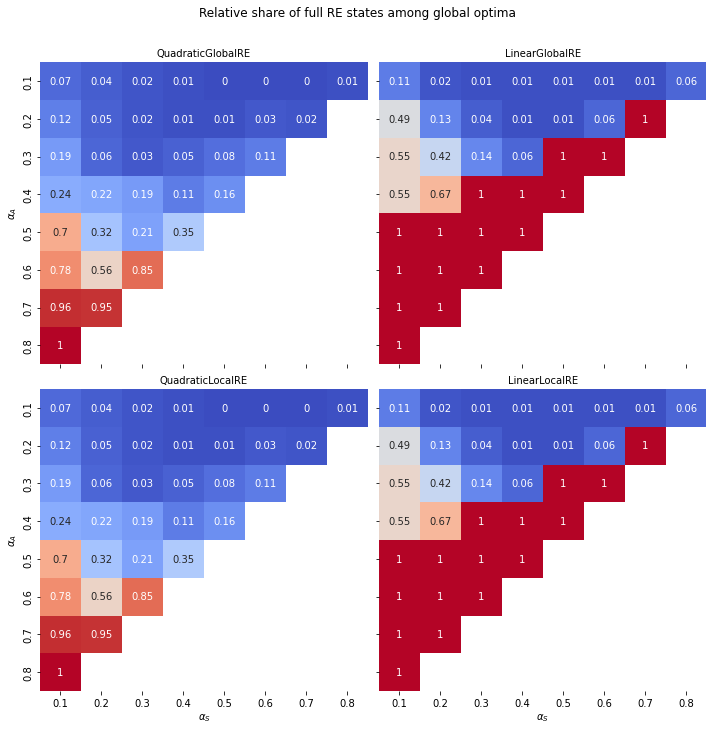

In [108]:
normalized_heat_maps_by_weights(wgrouped_go_data, 
                                "rel_go_full_re", 
                                "Relative share of full RE states among global optima",
                                annot_std = False,
                                #annot_fmt="{:2.2f}\n"
                               )
      
branches = "branches" if analyse_branches else "setups"
        
if export_results:
    plt.savefig(path.join(figures_output_dir, 'rel_go_full_re_{}.png'.format(branches)), bbox_inches='tight')
    plt.savefig(path.join(figures_output_dir, 'rel_go_full_re_{}.pdf'.format(branches)), bbox_inches='tight')

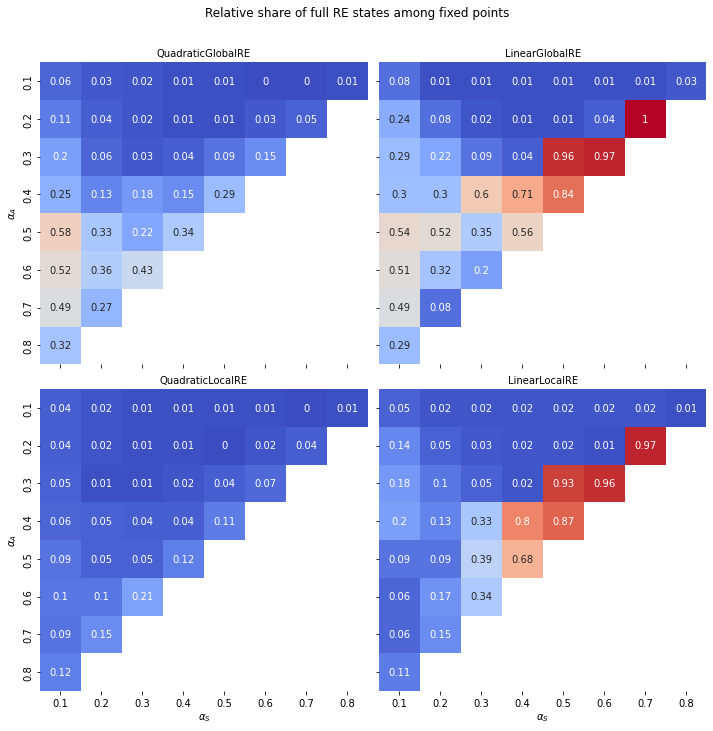

In [109]:
normalized_heat_maps_by_weights(wgrouped_fp_data, 
                                "rel_fp_full_re", 
                                "Relative share of full RE states among fixed points{}".format(" (all branches)" if analyse_branches else ""),
                                annot_std = False,
                                annot_fmt="{:2.2f}\n")

branches = "branches" if analyse_branches else "setups"
        
if export_results:
    plt.savefig(path.join(figures_output_dir, 'rel_fp_full_re_{}.png'.format(branches)), bbox_inches='tight')
    plt.savefig(path.join(figures_output_dir, 'rel_fp_full_re_{}.pdf'.format(branches)), bbox_inches='tight')